In [1]:
import pandas as pd
df = pd.read_pickle("arxiv_data_cs_all.pickle.bz2")
print(len(df))

180644


In [2]:
df.iloc[11,4]

'Transformer architectures show significant promise for natural language processing. Given that a single pretrained model can be fine-tuned to perform well on many different tasks, these networks appear to extract generally useful linguistic features. A natural question is how such networks represent this information internally. This paper describes qualitative and quantitative investigations of one particularly effective model, BERT. At a high level, linguistic features seem to be represented in separate semantic and syntactic subspaces. We find evidence of a fine-grained geometric representation of word senses. We also present empirical descriptions of syntactic representations in both attention matrices and individual word embeddings, as well as a mathematical argument to explain the geometry of these representations.'

In [3]:
df.iloc[11,5][0]

'Andy Coenen'

In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus

#remove tokens with a document frequency lower than 2
#remove tokens with a document frequency higher than 10%
#remove english stop words
#generate tokens with at least 3 letters, default pattern for 2 words: (?u)\b\w\w+\b

df_min = 2
df_max = 0.1

cvec = CountVectorizer(min_df=df_min, max_df=df_max, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')

trans = cvec.fit_transform(df.summary.tolist())

corpus = Sparse2Corpus(trans, documents_columns=False)

id_map = dict((v, k) for k, v in cvec.vocabulary_.items())

In [5]:
len(list(id_map))

66987

In [6]:
list(cvec.vocabulary_.keys())[11]

'ignoring'

In [7]:
"lda" in cvec.vocabulary_.keys()

True

### Build LDA Model
n_topics defines the amount of topics to generate

In [8]:
# 3223.79s
import time
from gensim.models.ldamodel import LdaModel

n_topics = 10
n_passes = 50

start_time = time.time()
ldamodel = LdaModel(corpus, num_topics=n_topics, random_state=0, passes=n_passes, id2word=id_map)
end_time = time.time()

temp_file = ("arxiv_data_cs_all"+"_ntopics_"+str(n_topics)
             +"_npasses_"+str(n_passes)
             +"_nvoc_"+str(len(list(id_map)))
            +"_dfmin_"+str(df_min)
            +"_dfmax_"+str(df_max*100))
ldamodel.save("lda/"+temp_file+".model")

print("Time elapsed: {}s".format(round(end_time-start_time,2)))

Running time is 11790.75s


In [218]:
lda_topics_5 = ldamodel.print_topics(num_topics=n_topics, num_words=5)
lda_topics_5

[(0,
  '0.012*"software" + 0.011*"systems" + 0.008*"web" + 0.008*"development" + 0.007*"applications"'),
 (1,
  '0.018*"channel" + 0.016*"network" + 0.013*"energy" + 0.013*"power" + 0.011*"performance"'),
 (2,
  '0.019*"network" + 0.018*"networks" + 0.011*"social" + 0.009*"information" + 0.007*"users"'),
 (3,
  '0.011*"logic" + 0.010*"theory" + 0.009*"systems" + 0.008*"language" + 0.006*"order"'),
 (4,
  '0.025*"graph" + 0.016*"graphs" + 0.013*"set" + 0.010*"polynomial" + 0.010*"bound"'),
 (5,
  '0.010*"method" + 0.009*"matrix" + 0.008*"linear" + 0.007*"methods" + 0.007*"function"'),
 (6,
  '0.017*"learning" + 0.014*"image" + 0.010*"method" + 0.008*"features" + 0.008*"classification"'),
 (7,
  '0.014*"algorithms" + 0.012*"performance" + 0.010*"computing" + 0.007*"method" + 0.007*"parallel"'),
 (8,
  '0.028*"codes" + 0.019*"quantum" + 0.015*"code" + 0.015*"information" + 0.012*"coding"'),
 (9,
  '0.016*"control" + 0.012*"game" + 0.012*"optimal" + 0.011*"agents" + 0.010*"games"')]

In [10]:
text_ode_abstract = "We introduce a new family of deep neural network models. Instead of specifying a discrete sequence of hidden layers, we parameterize the derivative of the hidden state using a neural network. The output of the network is computed using a black-box differential equation solver. These continuous-depth models have constant memory cost, adapt their evaluation strategy to each input, and can explicitly trade numerical precision for speed. We demonstrate these properties in continuous-depth residual networks and continuous-time latent variable models. We also construct continuous normalizing flows, a generative model that can train by maximum likelihood, without partitioning or ordering the data dimensions. For training, we show how to scalably backpropagate through any ODE solver, without access to its internal operations. This allows end-to-end training of ODEs within larger models."

In [11]:
from gensim.matutils import Sparse2Corpus
import numpy as np

def topic_distribution(abst_to_match, num_topics, count_vec, model):
    topics_array = np.zeros(num_topics)
    
    trans = count_vec.transform(list(abst_to_match))
    corpus = Sparse2Corpus(trans, documents_columns=False)
    results = list(model.get_document_topics(bow=corpus))[0]
    
    for items in results:
        topics_array[items[0]] = items[1]
    return topics_array

results = []
for i, item in enumerate(topic_distribution(text_ode_abstract, n_topics, cvec, ldamodel)):
    if item > 0:
        results.append([i,item])

results.sort(key=lambda x: x[1], reverse=True)

for r in results:
    print(round(r[1],2), lda_topics_5[r[0]],"\n")


0.1 (0, '0.010*"distribution" + 0.009*"probability" + 0.009*"random" + 0.009*"function" + 0.007*"error"') 

0.1 (1, '0.014*"channel" + 0.011*"power" + 0.011*"energy" + 0.009*"rate" + 0.008*"scheme"') 

0.1 (2, '0.015*"matrix" + 0.010*"sparse" + 0.008*"signal" + 0.008*"dimensional" + 0.007*"space"') 

0.1 (3, '0.011*"logic" + 0.010*"quantum" + 0.009*"theory" + 0.006*"properties" + 0.006*"complexity"') 

0.1 (4, '0.015*"classification" + 0.014*"training" + 0.012*"features" + 0.010*"neural" + 0.009*"feature"') 

0.1 (5, '0.022*"graph" + 0.014*"graphs" + 0.013*"bound" + 0.013*"codes" + 0.010*"bounds"') 

0.1 (6, '0.011*"social" + 0.009*"research" + 0.008*"users" + 0.007*"user" + 0.005*"web"') 

0.1 (7, '0.012*"software" + 0.008*"search" + 0.008*"computing" + 0.007*"implementation" + 0.007*"design"') 

0.1 (8, '0.020*"control" + 0.012*"game" + 0.010*"agents" + 0.009*"games" + 0.008*"agent"') 

0.1 (9, '0.030*"image" + 0.018*"images" + 0.013*"detection" + 0.011*"video" + 0.010*"object"') 



In [12]:
ldamodel.get_topic_terms(6, topn=10)

[(55680, 0.011437881),
 (50881, 0.0085247215),
 (63756, 0.008316529),
 (63751, 0.006690375),
 (65440, 0.0050740247),
 (53583, 0.004265664),
 (12449, 0.0041457308),
 (54078, 0.00408663),
 (42501, 0.0039500883),
 (47232, 0.0037868575)]

In [13]:
def get_score(abstract_1, abstract_2, num_topics, count_vec, model):
    return np.dot(topic_distribution(abstract_1, n_topics, cvec, ldamodel),
                  topic_distribution(abstract_2, n_topics, cvec, ldamodel))

In [14]:
def get_most_similar_paper(abstract, df, num_topics, count_vec, model):
    best_score = 0
    start_time = time.time()
    summaries = df.summary.tolist()
    for i, doc in enumerate(summaries):
        if abstract == doc:
            print("it's me at:",i)
            continue
        
        score = get_score(abstract, doc, num_topics, count_vec, model)
        print("\r\t>>> Progress\t:{:.2%}".format((i + 1)/len(summaries)), end='')

        if score > best_score:
            best_i = i
            best_score = score
        
    end_time = time.time()
    print("\nTime elapsed {}s".format(round(end_time-start_time,2)))
    return best_i, best_score

In [ ]:
best_i, best_score = get_most_similar_paper(text_ode_abstract, df, n_topics, cvec, ldamodel)

In [ ]:
print(">>> Best score is:", best_score)
print(">>> Abstract of the closest paper:")
print(df.summary[best_i])
print(">>> Abstract of initial paper:")
print(abstract)

In [ ]:
for i, item in enumerate(topic_distribution(df.summary[best_i]), n_topics, cvec, ldamodel):
    if item > 0:
        print(i, item)

In [19]:
summary = df.summary.tolist()

In [23]:
topic_distribution([summary[0]],n_topics,cvec,ldamodel)

array([0.        , 0.        , 0.08039915, 0.        , 0.24941969,
       0.06336612, 0.        , 0.        , 0.        , 0.59975463])

In [30]:
summary_len = len(summary)

In [ ]:
papers_df = pd.DataFrame()
for i in range(summary_len):
    print("\r\t>>> Progress\t:{:.2%}".format((i + 1)/summary_len), end='')
    for k in range(10):
        papers_df.loc[i, k] = topic_distribution([summary[i]],n_topics,cvec,ldamodel)[k]
papers_df.head()

In [33]:
papers_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,180644.000000,180644.000000,180644.000000,180644.000000,180644.000000,180644.000000,180644.000000,180644.000000,180644.000000,180644.000000
mean,0.106808,0.117729,0.086715,0.096656,0.102931,0.116628,0.119399,0.105897,0.068867,0.069535
std,0.153645,0.209588,0.145671,0.176655,0.181113,0.197873,0.185187,0.153533,0.121295,0.145008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.035985,0.000000,0.015821,0.000000,0.000000,0.018142,0.026214,0.033596,0.000000,0.000000
75%,0.160989,0.129646,0.112872,0.105934,0.127626,0.141316,0.165402,0.158722,0.084873,0.061561
max,0.989652,0.992241,0.983632,0.986153,0.990321,0.990623,0.982690,0.969994,0.963993,0.988155


In [52]:
paper_df_path = "pickles/arxiv_data_cs_all_ntopics_10_npasses_50_nvoc_66987_dfmin_2_dfmax_10_paperdf.pickle.bz2"
papers_df.to_pickle(paper_df_path, compression='bz2')

In [54]:
summary[141588]

'Multilayer networks are a useful data structure for simultaneously capturing multiple types of relationships between a set of nodes. In such networks, each relational definition gives rise to a layer. While each layer provides its own set of information, community structure across layers can be collectively utilized to discover and quantify underlying relational patterns between nodes. To concisely extract information from a multilayer network, we propose to identify and combine sets of layers with meaningful similarities in community structure. In this paper, we describe the "strata multilayer stochastic block model\'\' sMLSBM), a probabilistic model for multilayer community structure. The central extension of the model is that there exist groups of layers, called "strata\'\', which are defined such that all layers in a given stratum have community structure described by a common stochastic block model SBM). That is, layers in a stratum exhibit similar node-to-community assignments a

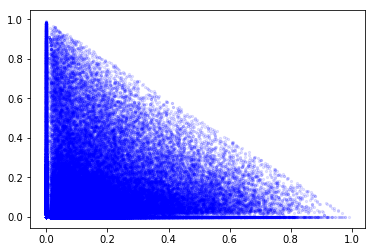

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(papers_df[0], papers_df[5], alpha=0.1, s=5, c='blue')
plt.show()

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
pca.fit(papers_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [38]:
papers_pca = pca.transform(papers_df)

In [39]:
papers_pca[:10]

array([[-0.17237264, -0.14571326],
       [-0.33578282, -0.13506409],
       [-0.11385845, -0.14786033],
       [-0.01492025, -0.16970094],
       [-0.18716394, -0.14636255],
       [-0.01252399, -0.17476399],
       [-0.31134503, -0.17416376],
       [-0.25322771, -0.03432315],
       [ 0.07655581, -0.16557814],
       [-0.13360486, -0.17511183]])

In [40]:
papers_pca[0]

array([-0.17237264, -0.14571326])

In [46]:
text_ode_abstract_df = pd.DataFrame(topic_distribution(text_ode_abstract,n_topics,cvec,ldamodel))
best_i = 100

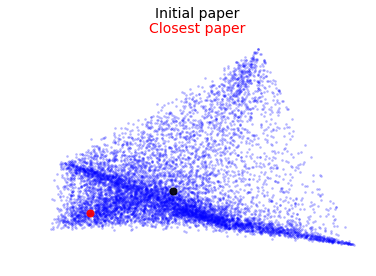

In [56]:
# plot each 20th paper:
for i in range(1, len(papers_pca), 20):
    plt.scatter(papers_pca[i][0], papers_pca[i][1], alpha=0.2, s=3, c='blue')
# plot
plt.scatter(papers_pca[best_i][0], papers_pca[best_i][1], alpha=0.9, s=50, c='red')
# plot 
#text_ode_abstract_df = pd.DataFrame(topic_distribution(text_ode_abstract))
plt.scatter(pca.transform(text_ode_abstract_df.T)[0][0], pca.transform(text_ode_abstract_df.T)[0][1], alpha=0.9, s=50, c='black')
plt.tick_params(axis ='both', which='major', length=0)
plt.tick_params(axis ='both', which='minor', length=0)
plt.axis('off')
plt.figtext(x=0.5, y=0.95, s='Initial paper', ha='center', size=14, color='black')
plt.figtext(x=0.5, y=0.9, s='Closest paper', ha='center', size=14, color='red')
plt.savefig("visual-2.png", format="png", transparent=True,rasterized=True,dpi=300)

plt.show()